In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingClassifier

In [4]:
#Here I want to test some regressors

import numpy as np
import h5py
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from scipy.spatial import cKDTree

In [80]:
#The correlation program is busted for reason that I don't quite understand
#as far as I can tell it has to be one of 3 things
#
# 1) a problem with the input particles either stars or dm
# 2) a problem with the NN algorithms
# 3) a problem with the sorting algorithms
#
# 1 is easy to check I just need to load up the particle data and plot it to see if it
# looks okay:

#Now it turns out my sample is very biased
#about 1% of the dm particles have associated stellar mass
#
#Apparently you can pass a bias to the network and it will
#work with that
#
#First load the data

f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')

pos_halo_train = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo_train = f_halo['velocity'][:]

h = 0.702

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos_train = pos_halo_train[host_id]
host_vel_train = vel_halo_train[host_id]

f_parts = h5py.File('../m12i_res_7100_cdm/output/snapshot_600.hdf5')

f_dm = f_parts['PartType1']
f_stars = f_parts['PartType4']

dm_coords = f_dm['Coordinates'][:]/h
dm_ids = f_dm['ParticleIDs'][:]
star_coords = f_stars['Coordinates'][:]/h
star_vel = f_stars['Velocities'][:]

f = h5py.File('DM_data_w_stars_training.hdf5')

coords_train = f['PartType1']['Coordinates'][:]
vel_train = f['PartType1']['Velocities'][:]
M_star_train = f['PartType1']['Stellar_Masses'][:]



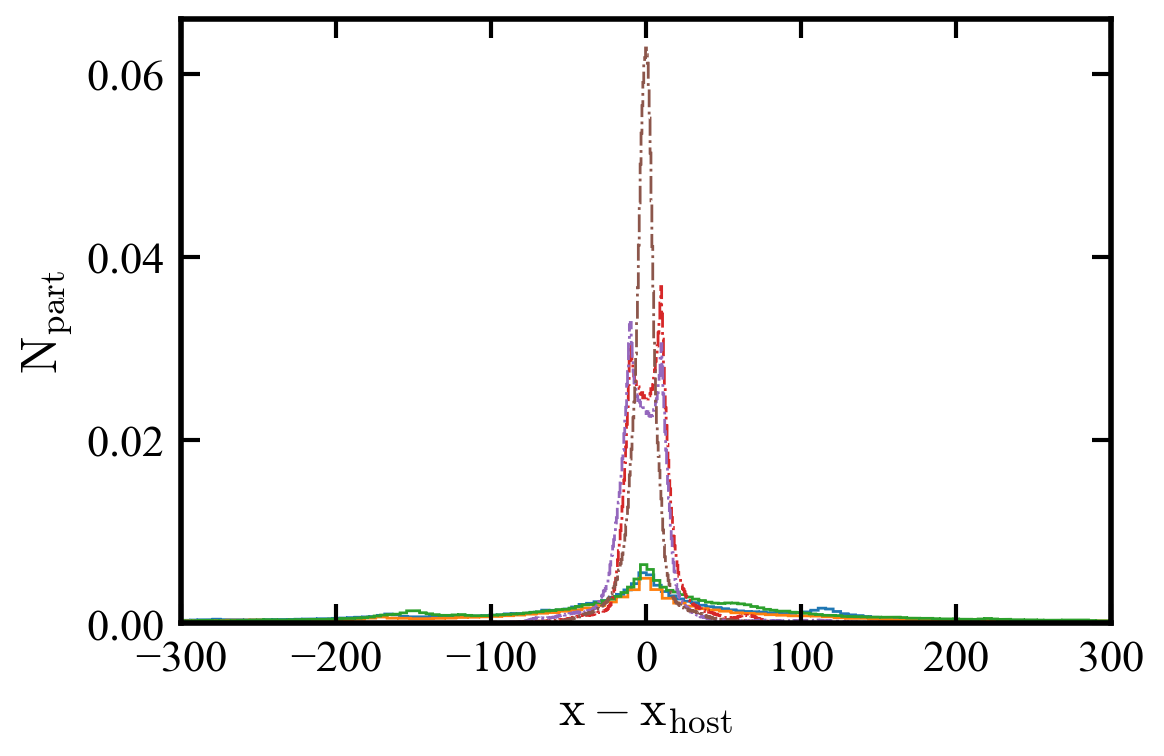

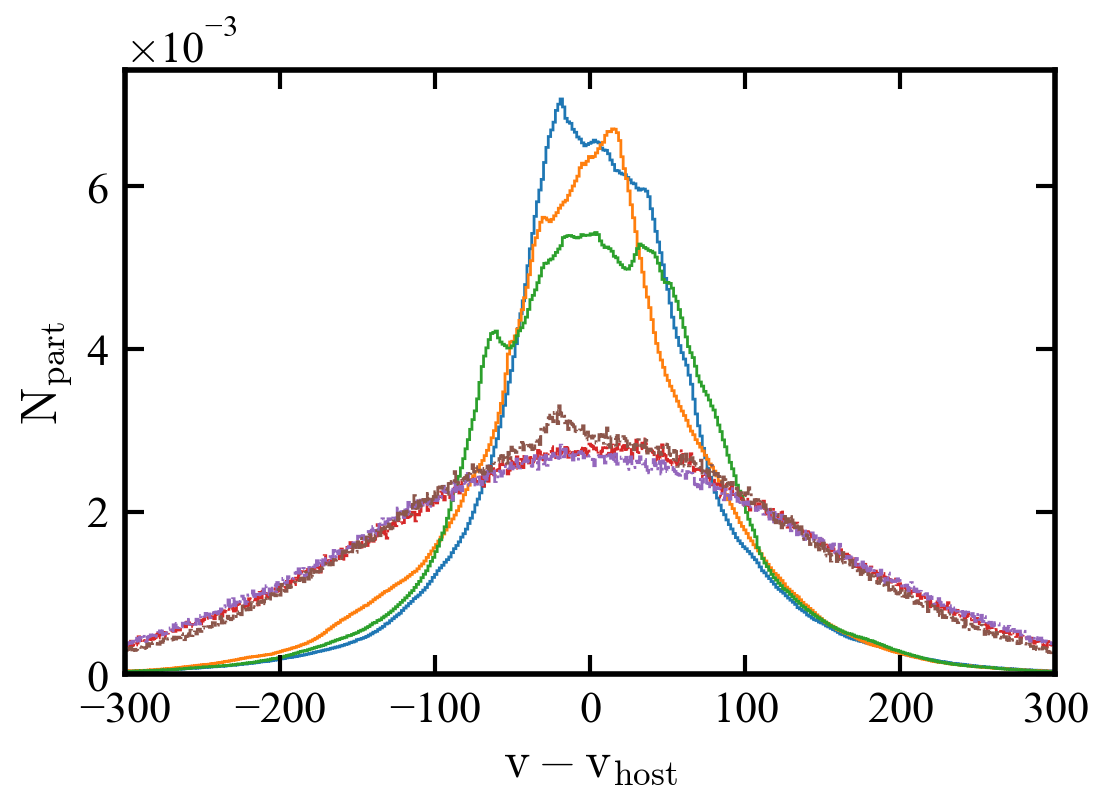

In [81]:
M_star_mask = (M_star_train>0.0)

plt.hist(coords_train[:,0] - host_pos_train[0],bins=1000,histtype='step',normed=True)
plt.hist(coords_train[:,1] - host_pos_train[1],bins=1000,histtype='step',normed=True)
plt.hist(coords_train[:,2] - host_pos_train[2],bins=1000,histtype='step',normed=True)

#plt.hist(star_coords[:,0] - host_pos[0],bins=np.linspace(-300.0,300.0,1000),linestyle='--',histtype='step',normed=True)
#plt.hist(star_coords[:,1] - host_pos[1],bins=np.linspace(-300.0,300.0,1000),linestyle='--',histtype='step',normed=True)
#plt.hist(star_coords[:,2] - host_pos[2],bins=np.linspace(-300.0,300.0,1000),linestyle='--',histtype='step',normed=True)

plt.hist(coords_train[:,0][M_star_mask] - host_pos_train[0],bins=1000,linestyle='-.',histtype='step',normed=True)
plt.hist(coords_train[:,1][M_star_mask] - host_pos_train[1],bins=1000,linestyle='-.',histtype='step',normed=True)
plt.hist(coords_train[:,2][M_star_mask] - host_pos_train[2],bins=1000,linestyle='-.',histtype='step',normed=True)

plt.xlabel(r'$\rm x - x_{host}$')
plt.ylabel(r'$\rm N_{part}$')
plt.xlim([-300.0,300.0])
plt.show()

plt.hist(vel_train[:,0] - host_vel_train[0],bins=1000,histtype='step',normed=True)
plt.hist(vel_train[:,1] - host_vel_train[1],bins=1000,histtype='step',normed=True)
plt.hist(vel_train[:,2] - host_vel_train[2],bins=1000,histtype='step',normed=True)

#plt.hist(star_vel[:,0] - host_vel[0],bins=1000,linestyle='--',histtype='step',normed=True)
#plt.hist(star_vel[:,1] - host_vel[1],bins=1000,linestyle='--',histtype='step',normed=True)
#plt.hist(star_vel[:,2] - host_vel[2],bins=1000,linestyle='--',histtype='step',normed=True)

plt.hist(vel_train[:,0][M_star_mask] - host_vel_train[0],bins=1000,linestyle='-.',histtype='step',normed=True)
plt.hist(vel_train[:,1][M_star_mask] - host_vel_train[1],bins=1000,linestyle='-.',histtype='step',normed=True)
plt.hist(vel_train[:,2][M_star_mask] - host_vel_train[2],bins=1000,linestyle='-.',histtype='step',normed=True)


plt.xlabel(r'$\rm v - v_{host}$')
plt.ylabel(r'$\rm N_{part}$')
plt.xlim([-300.0,300.0])
plt.show()

In [70]:
print float(np.sum(M_star_mask))/float(len(M_star))

0.00415639565965


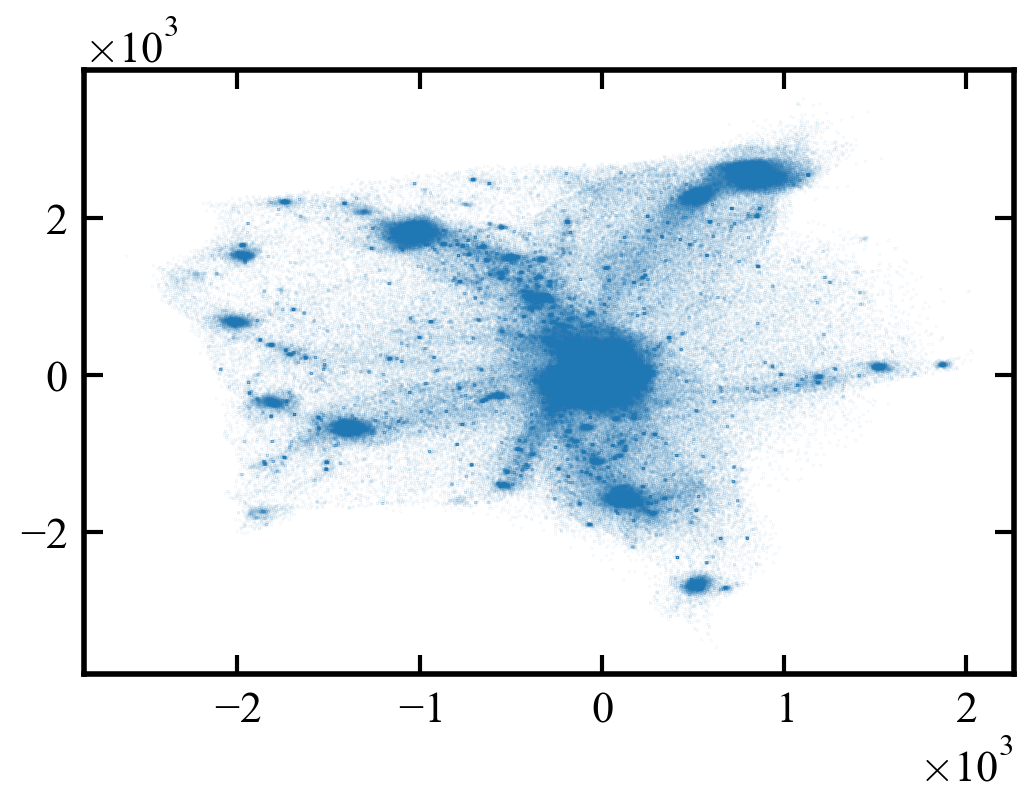

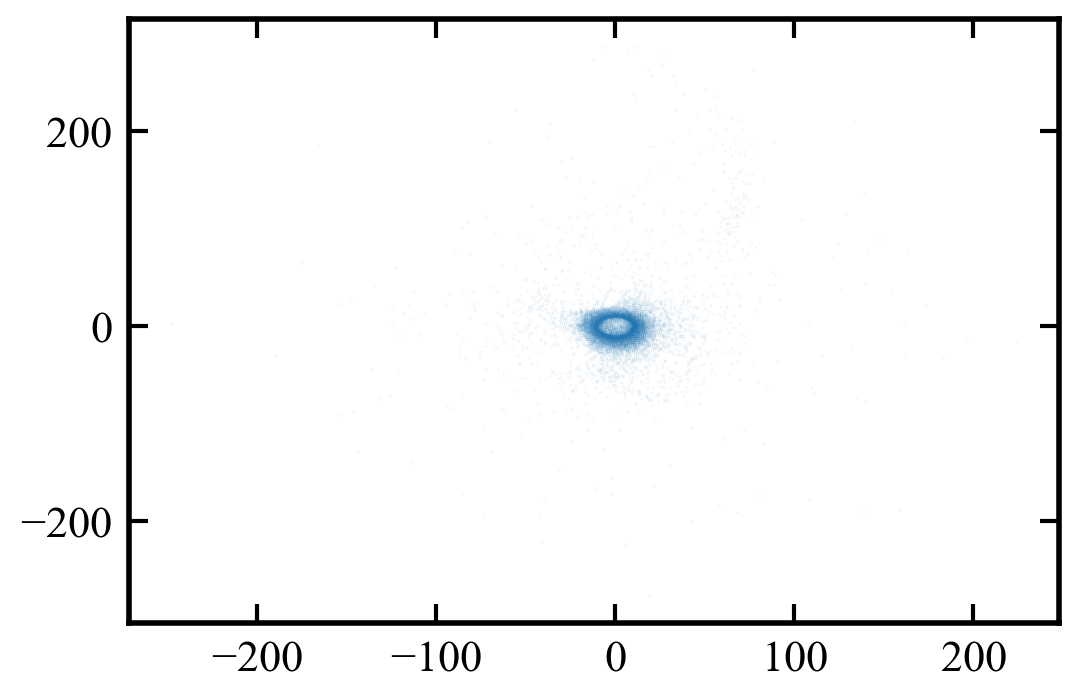

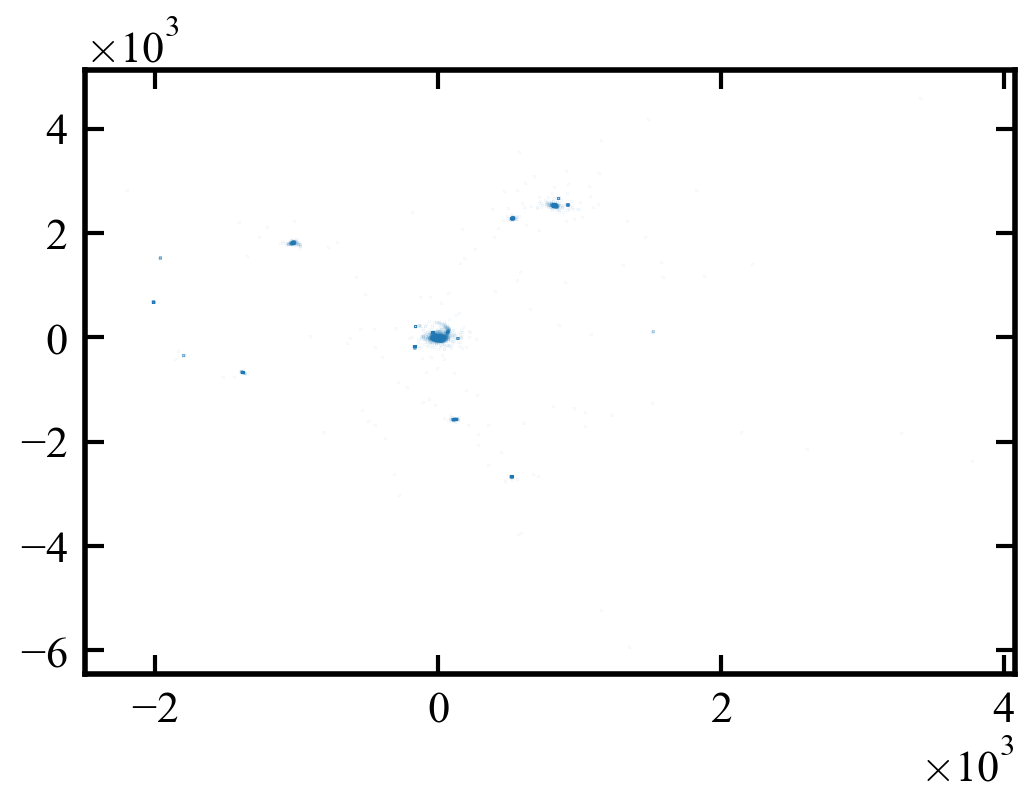

In [69]:

M_star_mask = (M_star>0.0)

plt.scatter(dm_coords[:,0][::100]-host_pos[0],
            dm_coords[:,1][::100]-host_pos[1],marker='.',s=0.001)
plt.show()

plt.scatter(coords[:,0][M_star_mask][::100]-host_pos[0],
            coords[:,1][M_star_mask][::100]-host_pos[1],marker='.',s=0.001)

plt.show()

plt.scatter(star_coords[:,0][::100]-host_pos[0],
            star_coords[:,1][::100]-host_pos[1],marker='.',s=0.001)
plt.show()

[41707.805 43950.113 46278.164]
[[41866.74163814 44123.3760767  46260.63682077]
 [41866.84140088 44123.22824792 46260.64134915]
 [41866.7360405  44123.30168354 46260.80846773]
 ...
 [42730.1136329  46761.23147086 46997.30692914]
 [42734.22157894 46754.88274908 47000.96673729]
 [42733.93747037 46751.94792243 47002.57516862]]
0.09961032095827205


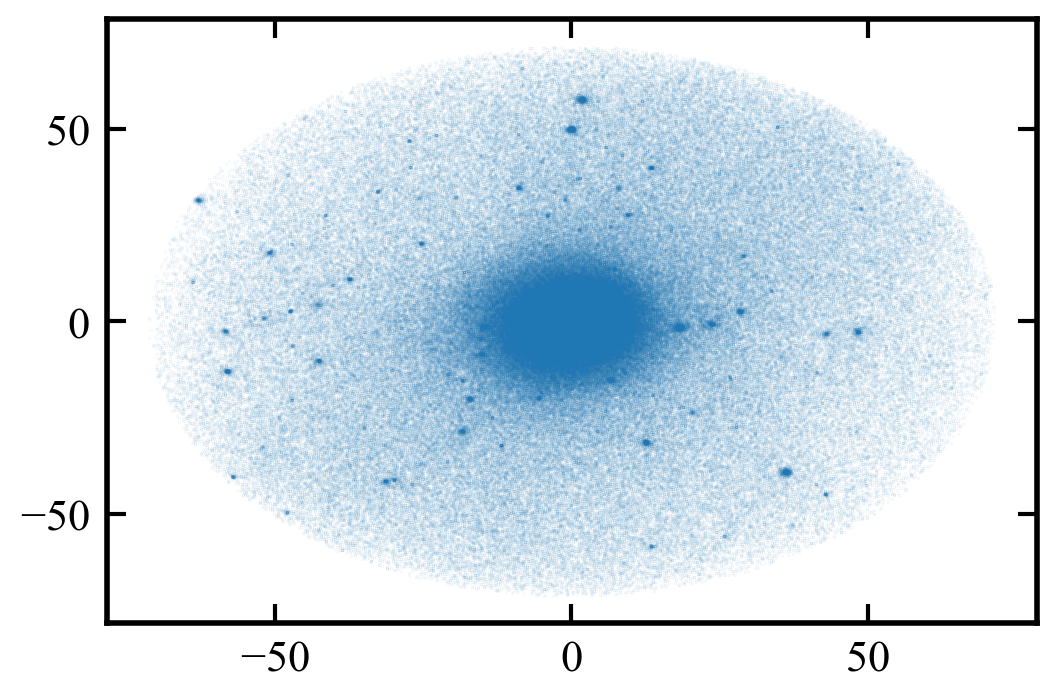

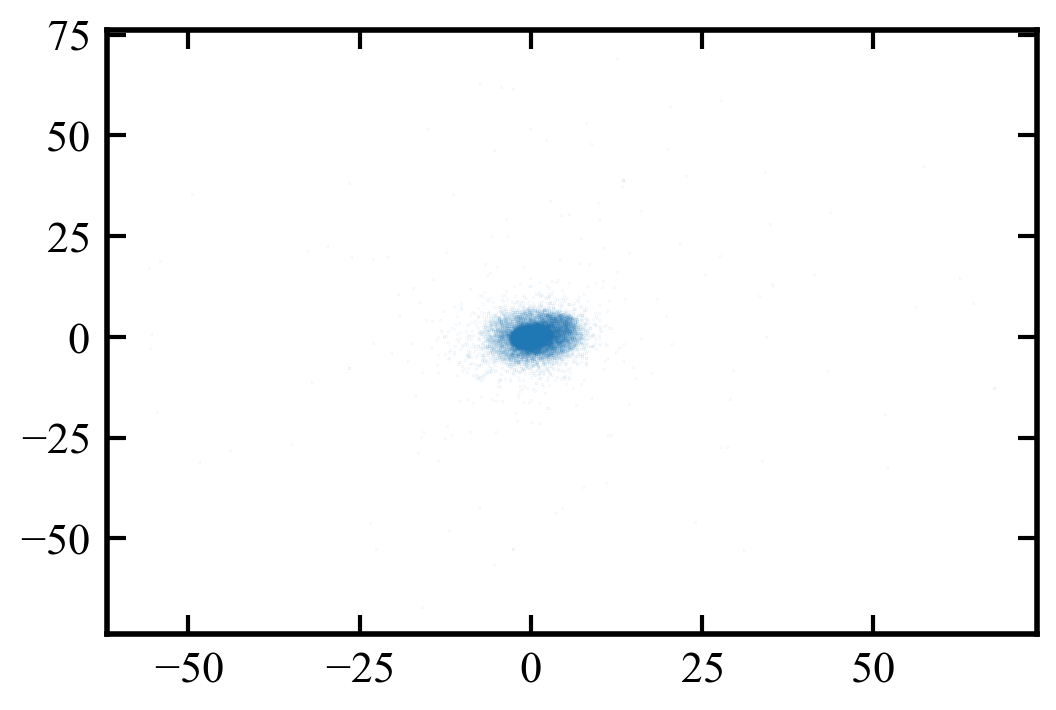

In [52]:
#The particles seem fine, now I need to test the tree algorithm
#Lets try something simpler, and possibly faster, focus in on a small dwarf and try to run
#the correlation on that

dist_halo = np.linalg.norm(pos_halo-host_pos,axis=1)
sat_mask = (dist_halo<300.0)&(dist_halo>0.0)&(mass_halo>5.0e9)&(mass_halo<2.5e10)

sat_pos = pos_halo[sat_mask][0]
sat_rad = radius_halo[sat_mask][0]

print(sat_pos)
print(dm_coords)

sat_dist_dm = np.linalg.norm(dm_coords-sat_pos,axis=1)
sat_dist_star = np.linalg.norm(star_coords-sat_pos,axis=1)

print(np.min(sat_dist_dm))

sat_coords_dm = dm_coords[sat_dist_dm<sat_rad] - sat_pos
sat_ids_dm = dm_ids[sat_dist_dm<sat_rad]
sat_coords_star = star_coords[sat_dist_star<sat_rad] - sat_pos

plt.scatter(sat_coords_dm[:,0],
            sat_coords_dm[:,1],marker='.',s=0.001)
plt.show()

plt.scatter(sat_coords_star[:,0],
            sat_coords_star[:,1],marker='.',s=0.001)
plt.show()

In [35]:
tree = cKDTree(sat_coords_dm)

NN_dist, NN_indicies = tree.query(sat_coords_star, k = 1)

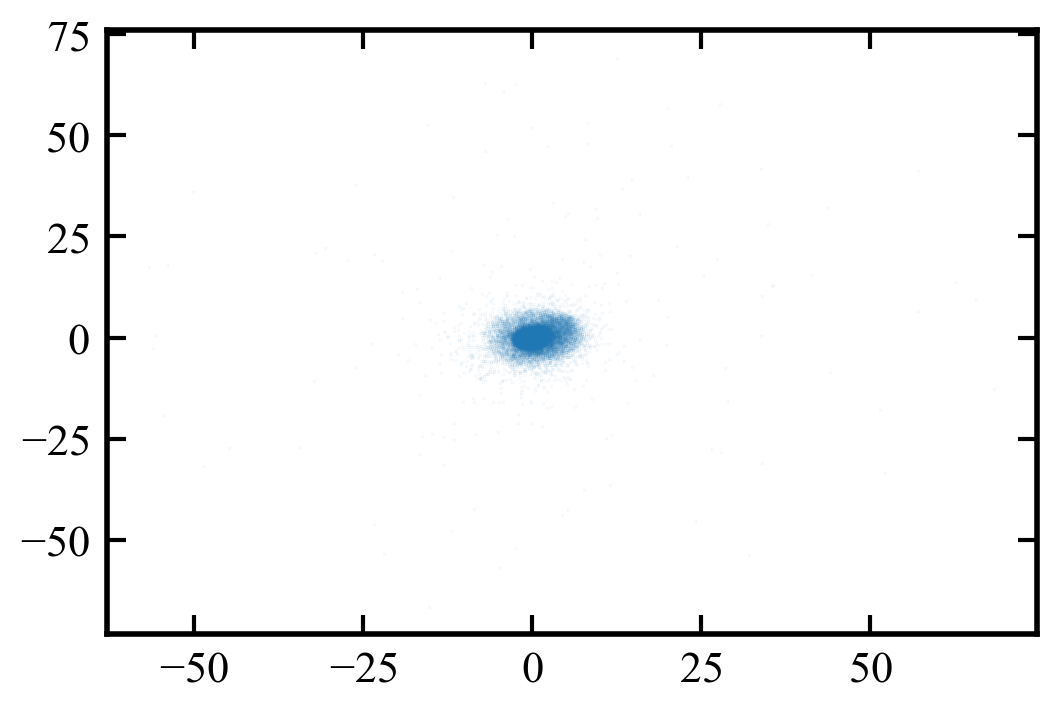

In [40]:
coords_with_stars = sat_coords_dm[np.unique(NN_indicies)]
#coords_with_stars = sat_coords_dm[NN_indicies]

plt.scatter(coords_with_stars[:,0],
            coords_with_stars[:,1],marker='.',s=0.001)
plt.show()

In [67]:
f['PartType1'].keys()

[u'Coordinates', u'Masses', u'ParticleIDs', u'Stellar_Masses', u'Velocities']

In [58]:
print(len(sat_ids_dm),len(sat_coords_dm))

part_ids_NN = sat_ids_dm[np.unique(NN_indicies)]

print NN_indicies, part_ids_NN

(542814, 542814)
[   327    327 102557 ... 532852 490425 536668] [98973600 75074115 76489610 ... 79687942 77826469 74624974]


In [59]:
#Now I have the list of particle ids in the form of part_ids_NN

star_ref_mask = np.in1d(dm_ids,part_ids_NN)

dm_ids_with_stars = part_ids_NN
dm_ids_without_stars = dm_ids[~star_ref_mask]

print(len(dm_ids),len(dm_ids_with_stars)+len(dm_ids_without_stars))

#so then apply 

(70514272, 70514272)


In [73]:
parts.keys()

[u'Coordinates', u'Mass_Ratio', u'Masses', u'ParticleIDs', u'Velocities']

In [59]:
#alright now I'm going to try to apply to data

f = h5py.File('../halo_1107_Z13/halo_1107_Z13_particles.hdf5')

h = 0.675

parts = f['PartType1']
coords = parts['Coordinates'][:]/h
vel = parts['Velocities'][:]
mass= parts['Masses'][:]*1.0e10/h
ids = parts['ParticleIDs'][:]
M_star = parts['Mass_Ratio'][:]

host_cen = np.array([37.53820323, 34.52403051, 37.02327211])*1000.0
host_vel = np.array([ 57.161152, -83.112122, -17.277088])

coord_diff = np.subtract(coords,host_cen)
vel_diff = np.subtract(vel,host_vel)

In [11]:
print coords
print host_cen

[[36441.96973376 35014.35929846 34880.51071779]
 [36442.1859967  35014.19091147 34880.78989903]
 [36442.22599593 35014.23654645 34880.76989525]
 ...
 [37538.13372781 33278.21164545 40089.12133394]
 [37543.17173479 33273.85900792 40096.38128556]
 [37539.42970605 33273.84825119 40091.1226565 ]]
[37538.20323 34524.03051 37023.27211]


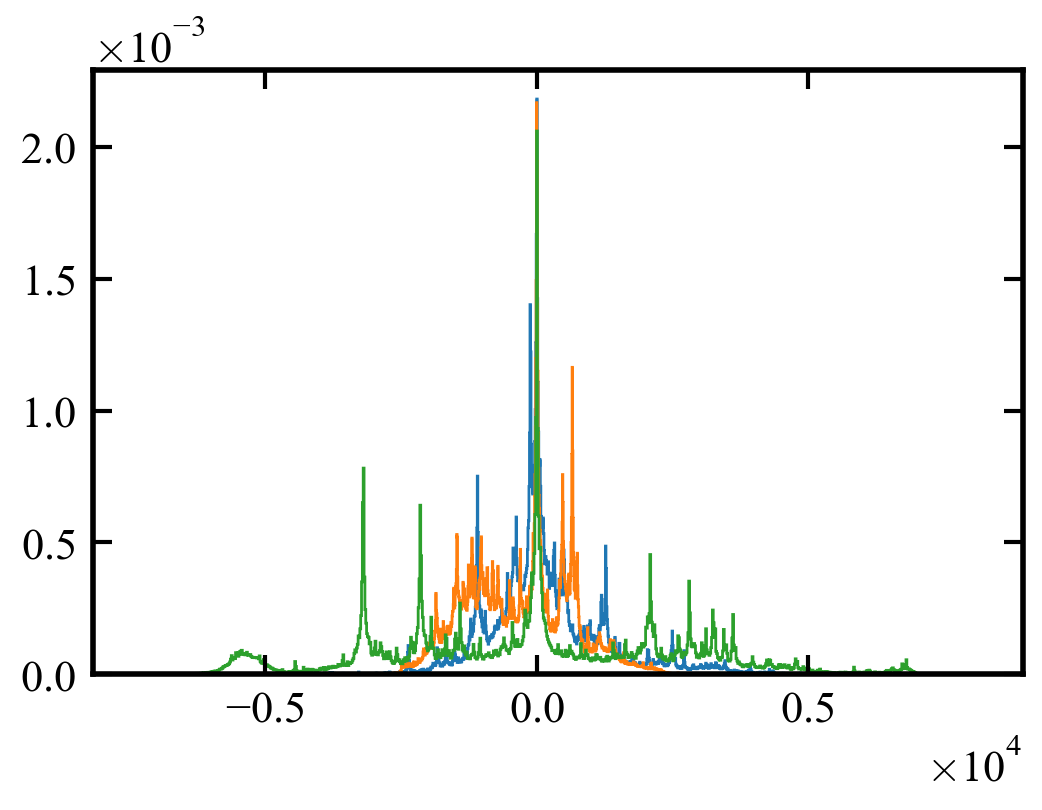

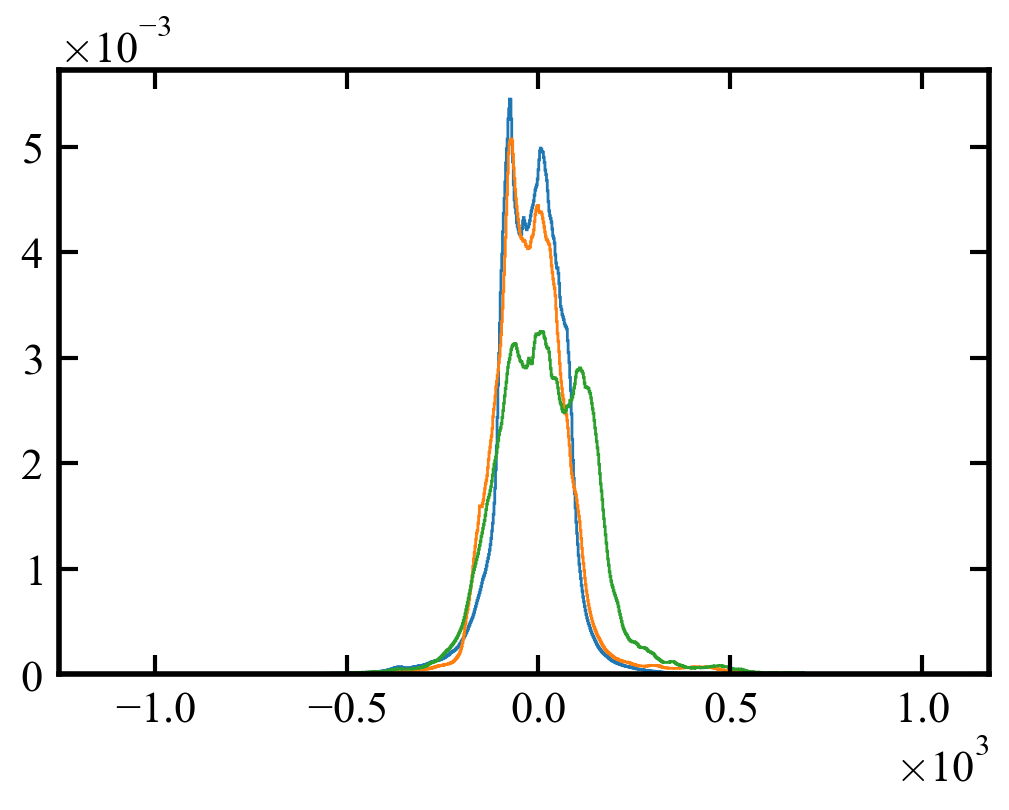

In [13]:
plt.hist(coord_diff[:,0],bins=1000,histtype='step',normed=True)
plt.hist(coord_diff[:,1],bins=1000,histtype='step',normed=True)
plt.hist(coord_diff[:,2],bins=1000,histtype='step',normed=True)
plt.show()

plt.hist(vel_diff[:,0],bins=1000,histtype='step',normed=True)
plt.hist(vel_diff[:,1],bins=1000,histtype='step',normed=True)
plt.hist(vel_diff[:,2],bins=1000,histtype='step',normed=True)
plt.show()

In [14]:
model = tf.keras.models.load_model('./saved_models/Classifier_biased_sigmoid.h5')

In [22]:
phase_space_coords = np.concatenate((coord_diff,vel_diff),axis=1)

#model_output = model.predict(phase_space_coords)

In [25]:
dist = np.linalg.norm(coord_diff,axis=1)

241063672
(241063672, 3)
(241063672, 6)


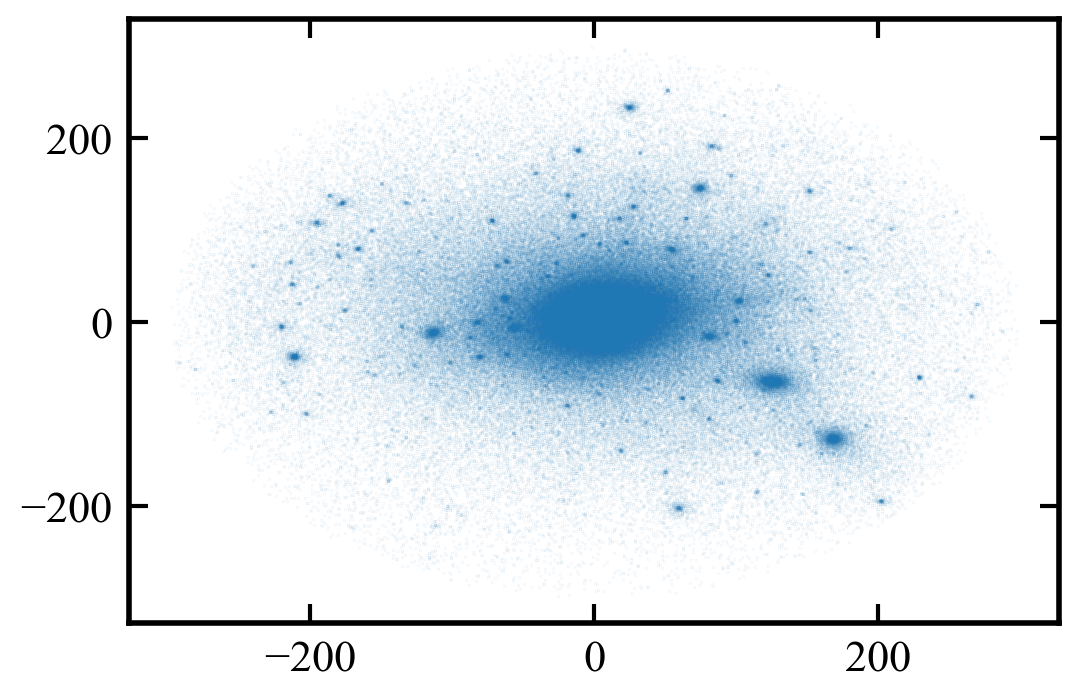

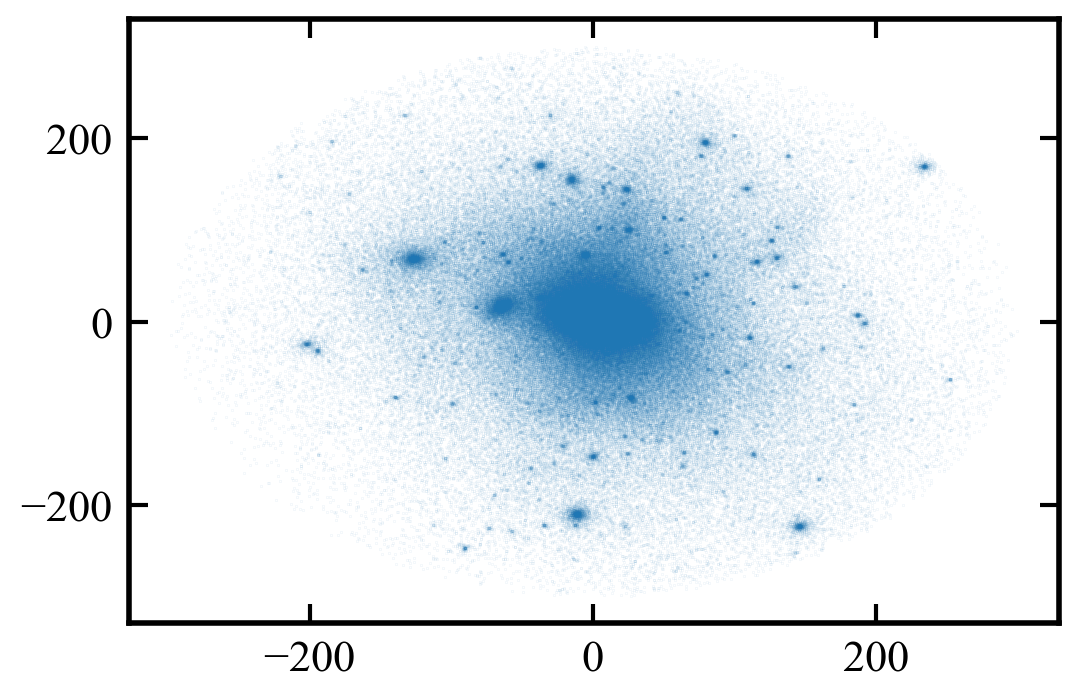

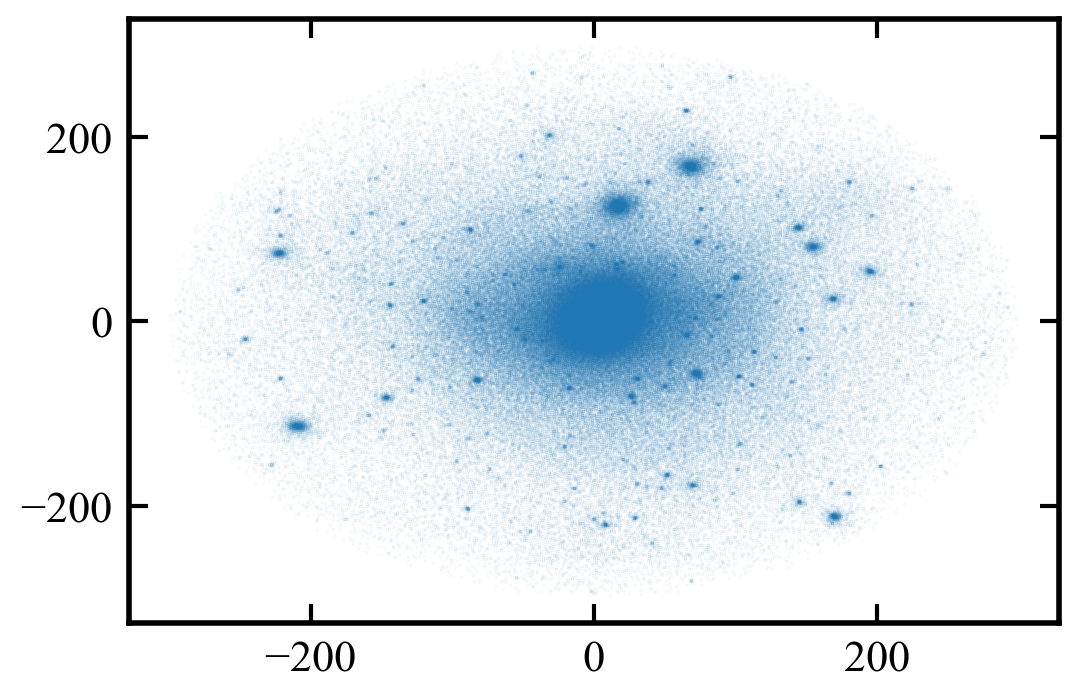

In [27]:
print len(model_output)
print coords.shape
print phase_space_coords.shape

mock_star_mask = np.ndarray.flatten((model_output>0.0))
in_gal_mask = (dist<300.0)

dark_part_coords = coords[mock_star_mask&in_gal_mask]

plt.scatter(dark_part_coords[:,0][::100]-host_cen[0],
            dark_part_coords[:,1][::100]-host_cen[1],marker='.',s=0.001)
plt.show()

plt.scatter(dark_part_coords[:,1][::100]-host_cen[1],
            dark_part_coords[:,2][::100]-host_cen[2],marker='.',s=0.001)
plt.show()

plt.scatter(dark_part_coords[:,2][::100]-host_cen[2],
            dark_part_coords[:,0][::100]-host_cen[0],marker='.',s=0.001)
plt.show()

241063672
(241063672, 3)
(241063672, 6)


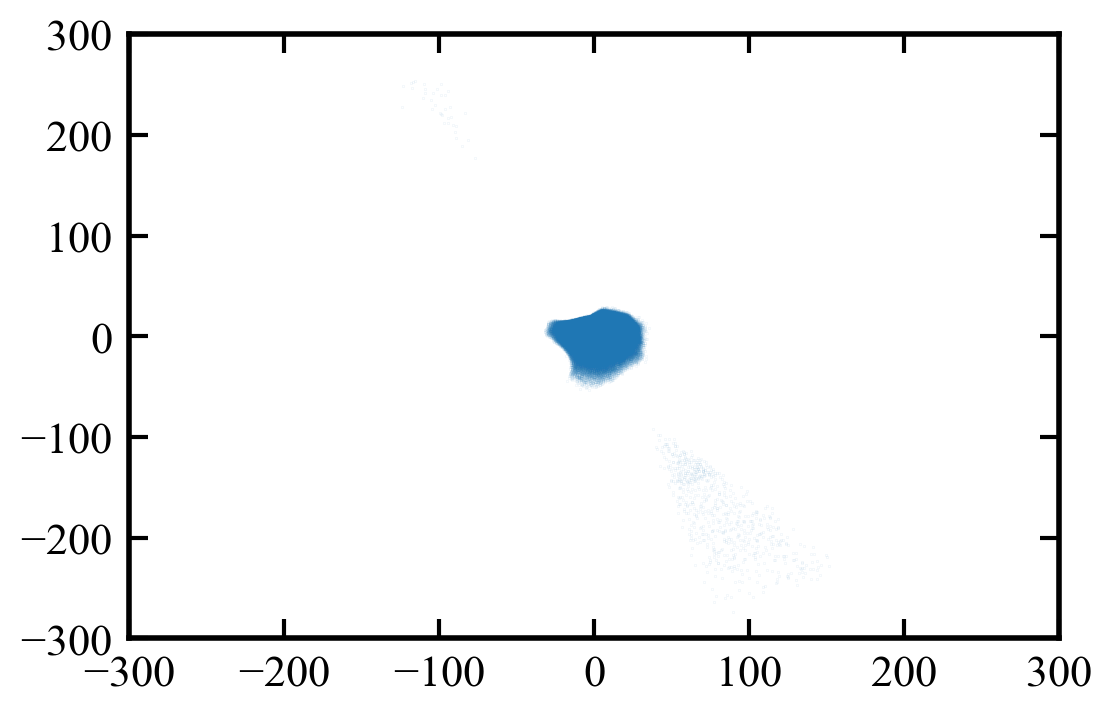

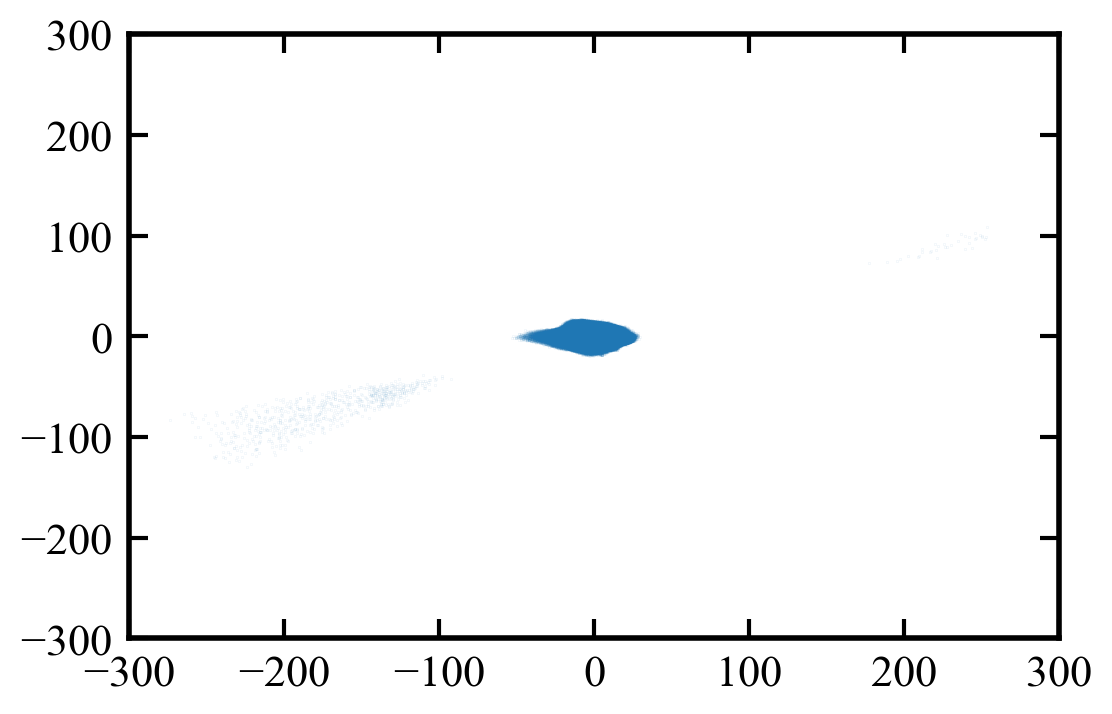

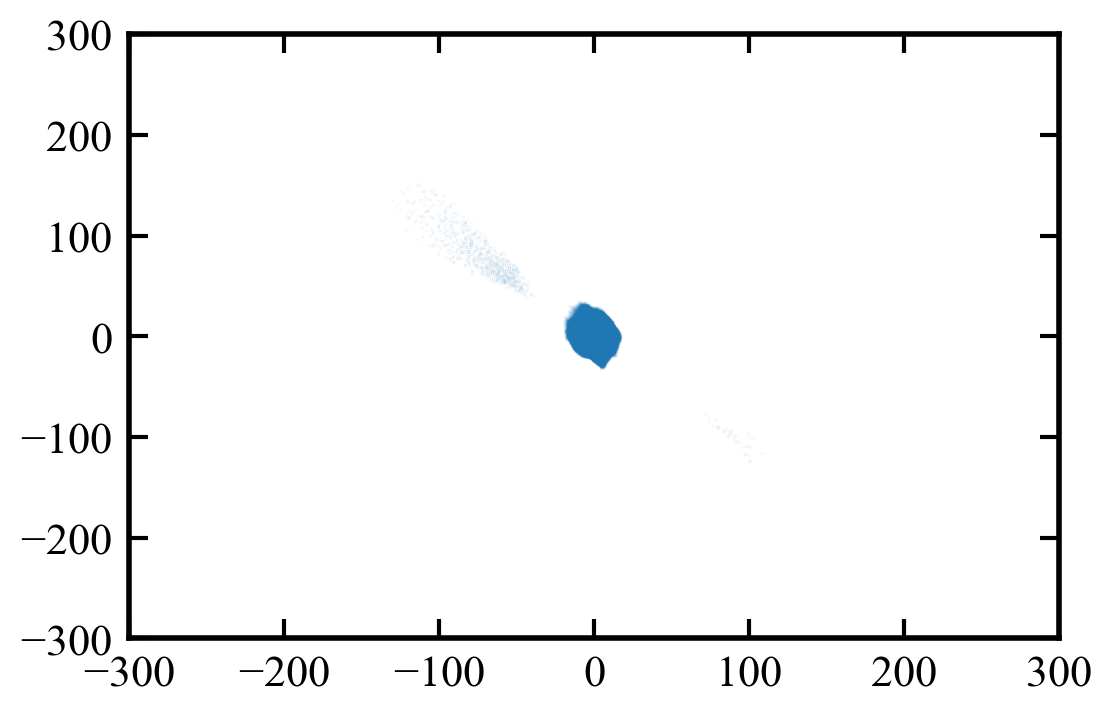

In [35]:
print len(model_output)
print coords.shape
print phase_space_coords.shape

mock_star_mask = np.ndarray.flatten((model_output>0.10))
in_gal_mask = (dist<300.0)

dark_part_coords = coords[mock_star_mask&in_gal_mask]

plt.scatter(dark_part_coords[:,0][::10]-host_cen[0],
            dark_part_coords[:,1][::10]-host_cen[1],marker='.',s=0.001)

plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(dark_part_coords[:,1][::10]-host_cen[1],
            dark_part_coords[:,2][::10]-host_cen[2],marker='.',s=0.001)
plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(dark_part_coords[:,2][::10]-host_cen[2],
            dark_part_coords[:,0][::10]-host_cen[0],marker='.',s=0.001)
plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

241063672
(241063672, 3)
(241063672, 6)


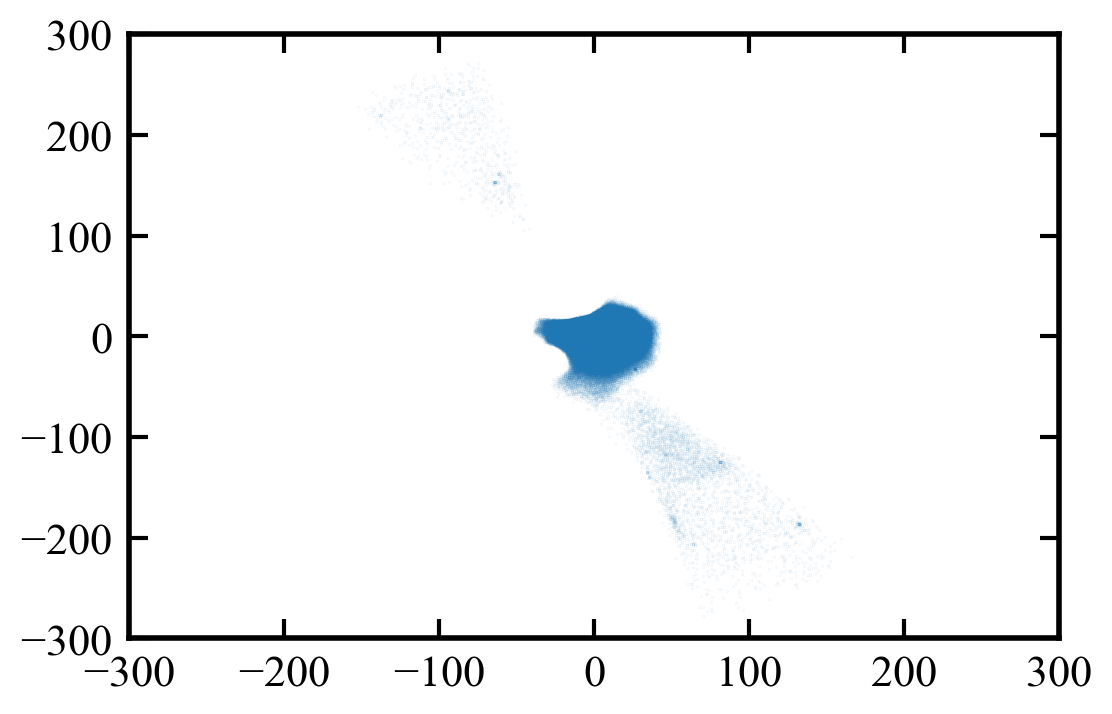

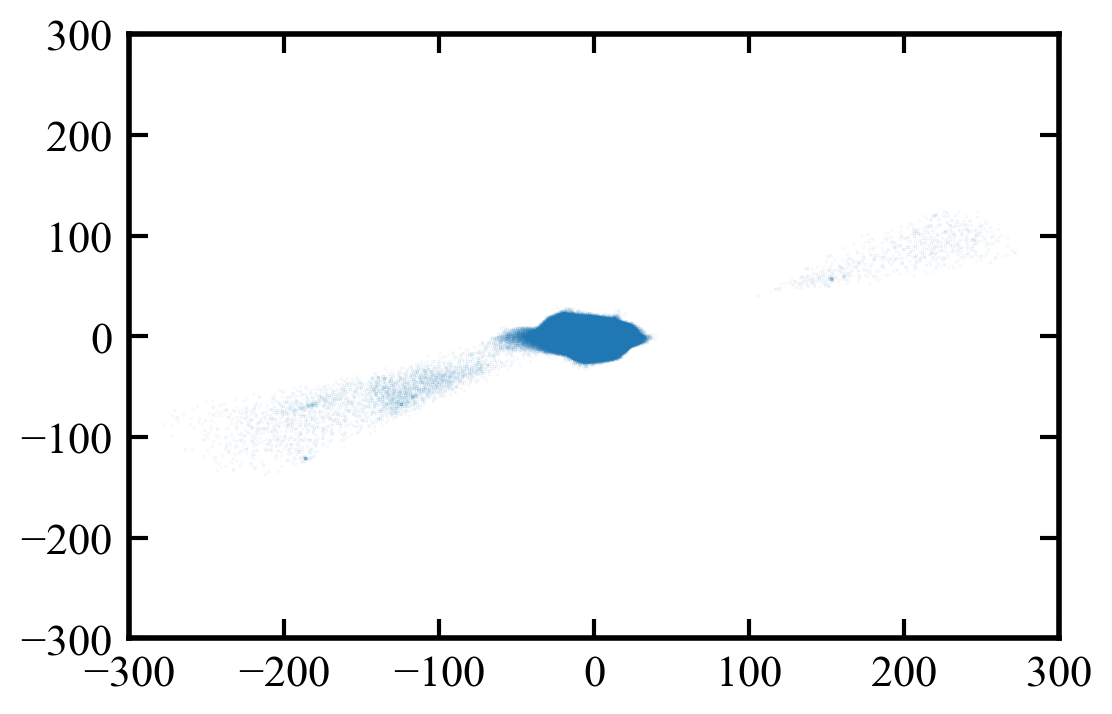

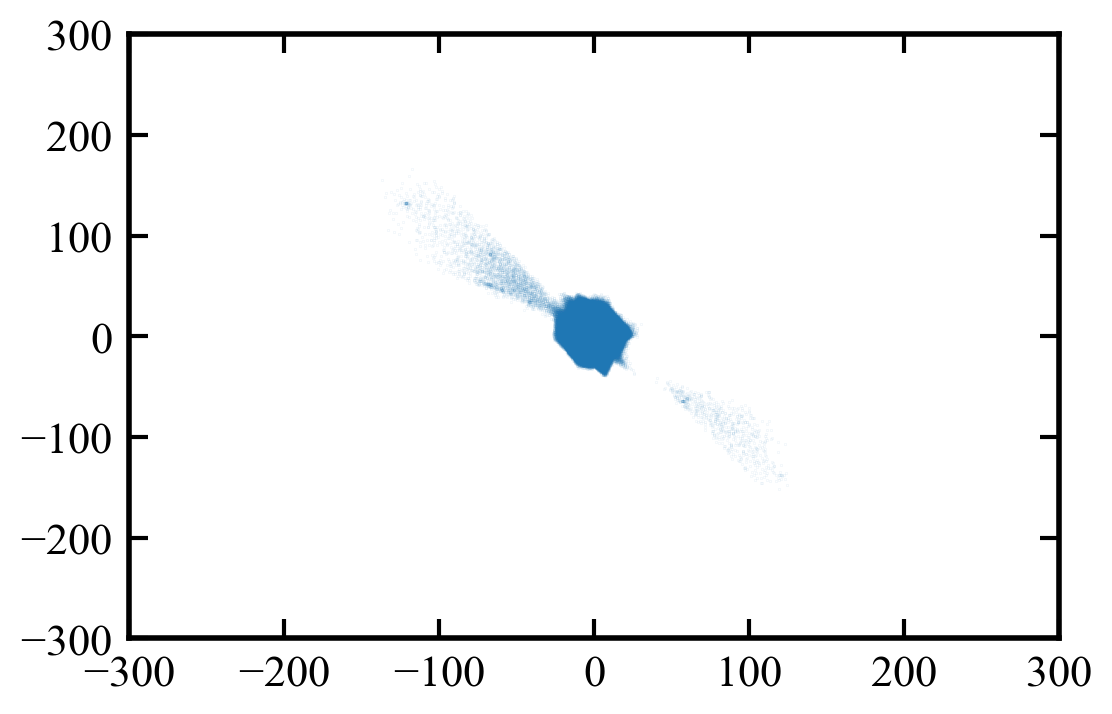

In [36]:
print len(model_output)
print coords.shape
print phase_space_coords.shape

mock_star_mask = np.ndarray.flatten((model_output>0.05))
in_gal_mask = (dist<300.0)

dark_part_coords = coords[mock_star_mask&in_gal_mask]

plt.scatter(dark_part_coords[:,0][::10]-host_cen[0],
            dark_part_coords[:,1][::10]-host_cen[1],marker='.',s=0.001)
plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(dark_part_coords[:,1][::10]-host_cen[1],
            dark_part_coords[:,2][::10]-host_cen[2],marker='.',s=0.001)
plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

plt.scatter(dark_part_coords[:,2][::10]-host_cen[2],
            dark_part_coords[:,0][::10]-host_cen[0],marker='.',s=0.001)
plt.xlim([-300.0,300.0])
plt.ylim([-300.0,300.0])
plt.show()

In [86]:
print host_cen

coords

[37538.20323 34524.03051 37023.27211]


array([[36441.96973376, 35014.35929846, 34880.51071779],
       [36442.1859967 , 35014.19091147, 34880.78989903],
       [36442.22599593, 35014.23654645, 34880.76989525],
       ...,
       [37538.13372781, 33278.21164545, 40089.12133394],
       [37543.17173479, 33273.85900792, 40096.38128556],
       [37539.42970605, 33273.84825119, 40091.1226565 ]])

In [37]:
(float(len(model_output)) - float(np.sum(model_output>0.0)))/float(len(model_output))

0.6014033006184358

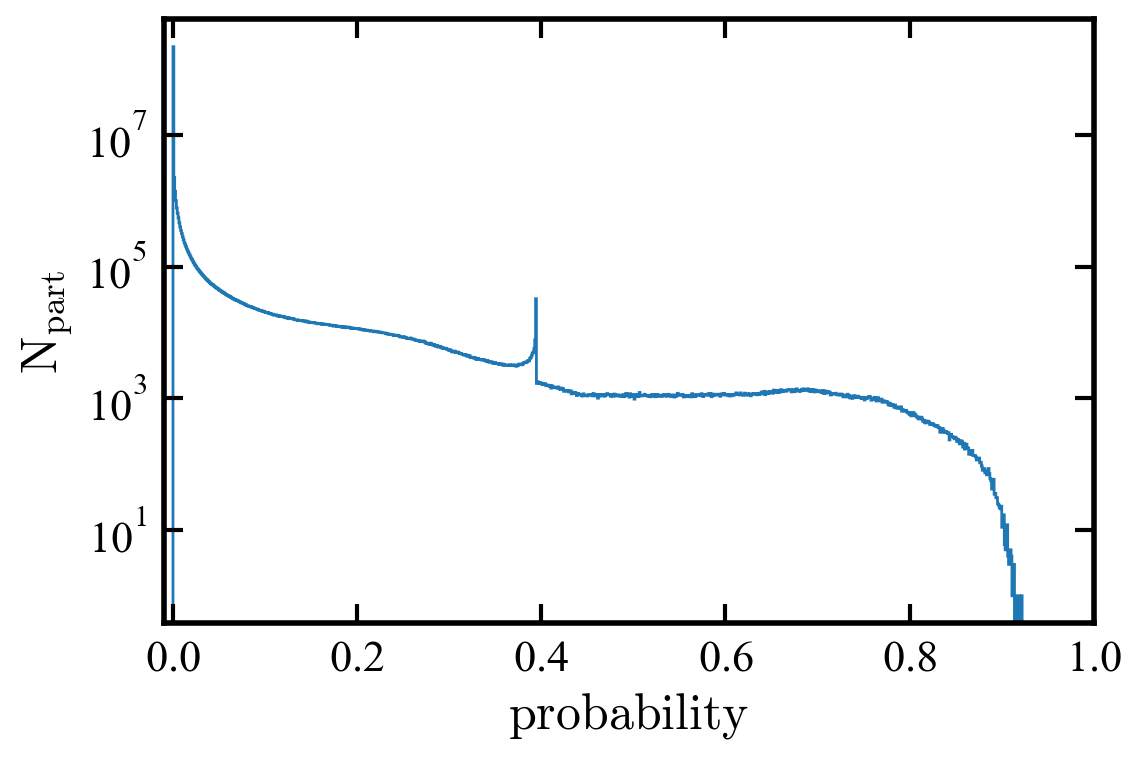

In [46]:
plt.hist(model_output,bins=1000,histtype='step')
plt.yscale('log')
plt.xlim([-0.01,1.0])
plt.xlabel(r'$\rm probability$')
plt.ylabel(r'$\rmN_{part}$')
plt.show()

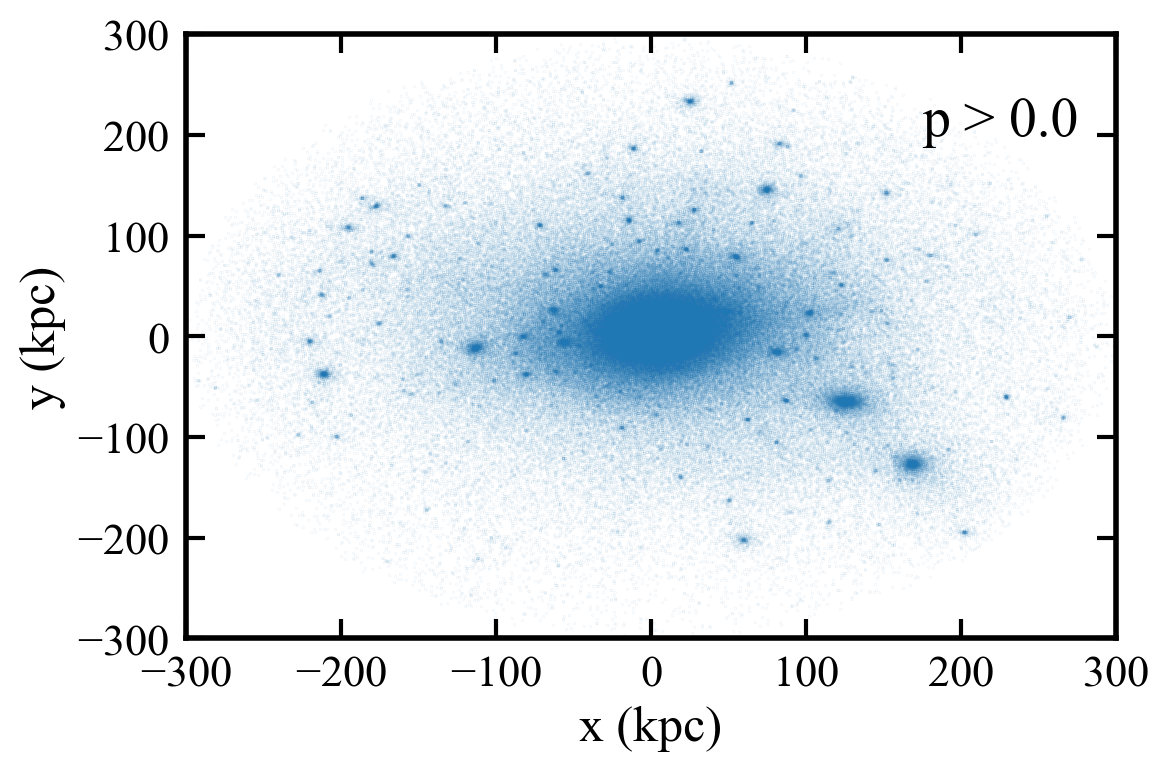

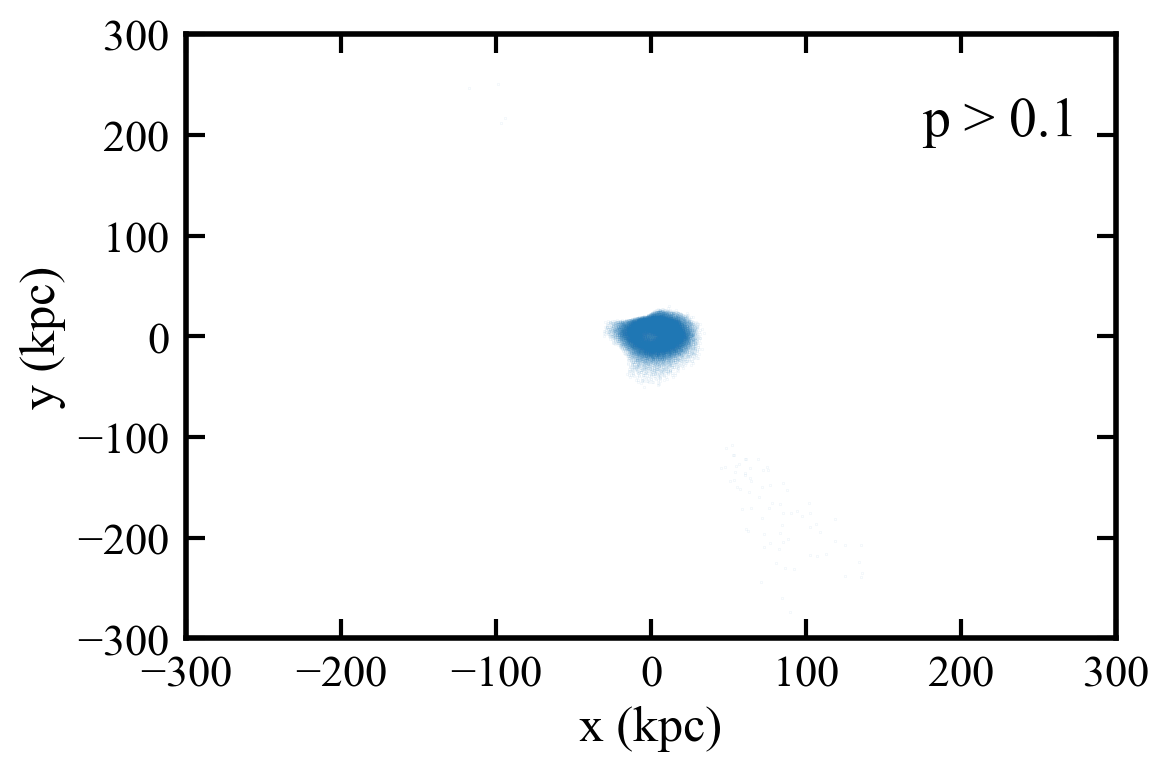

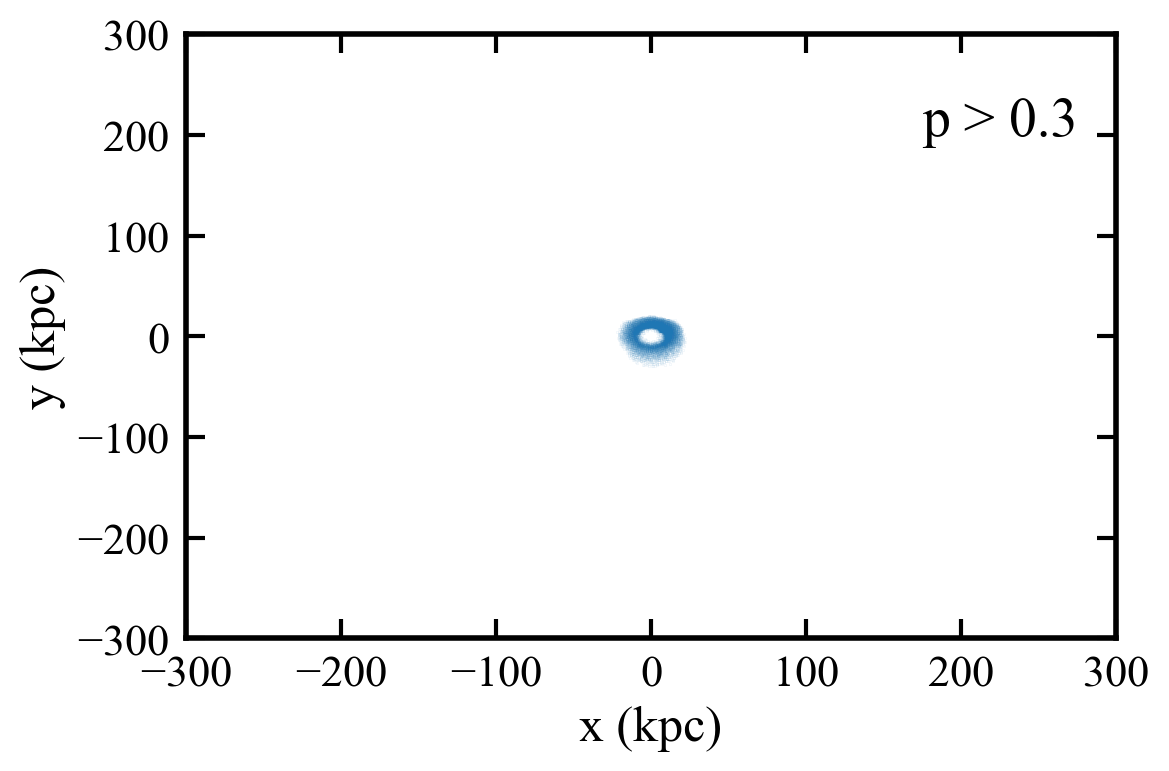

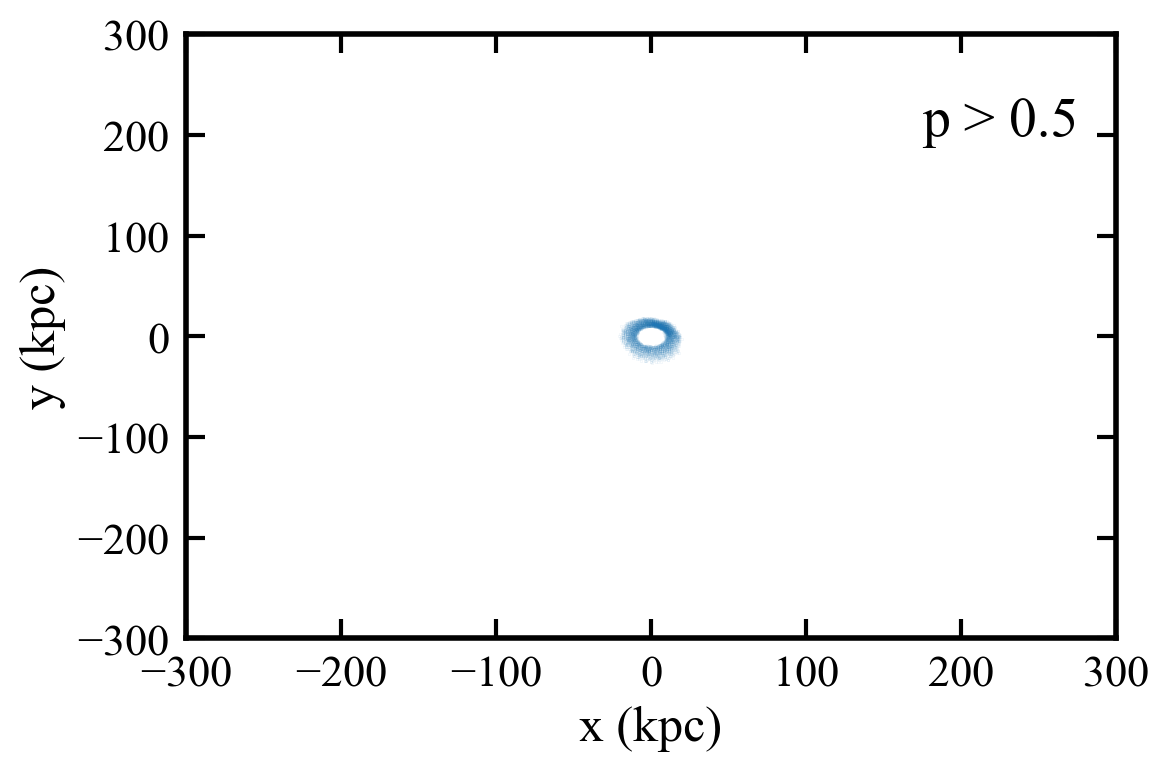

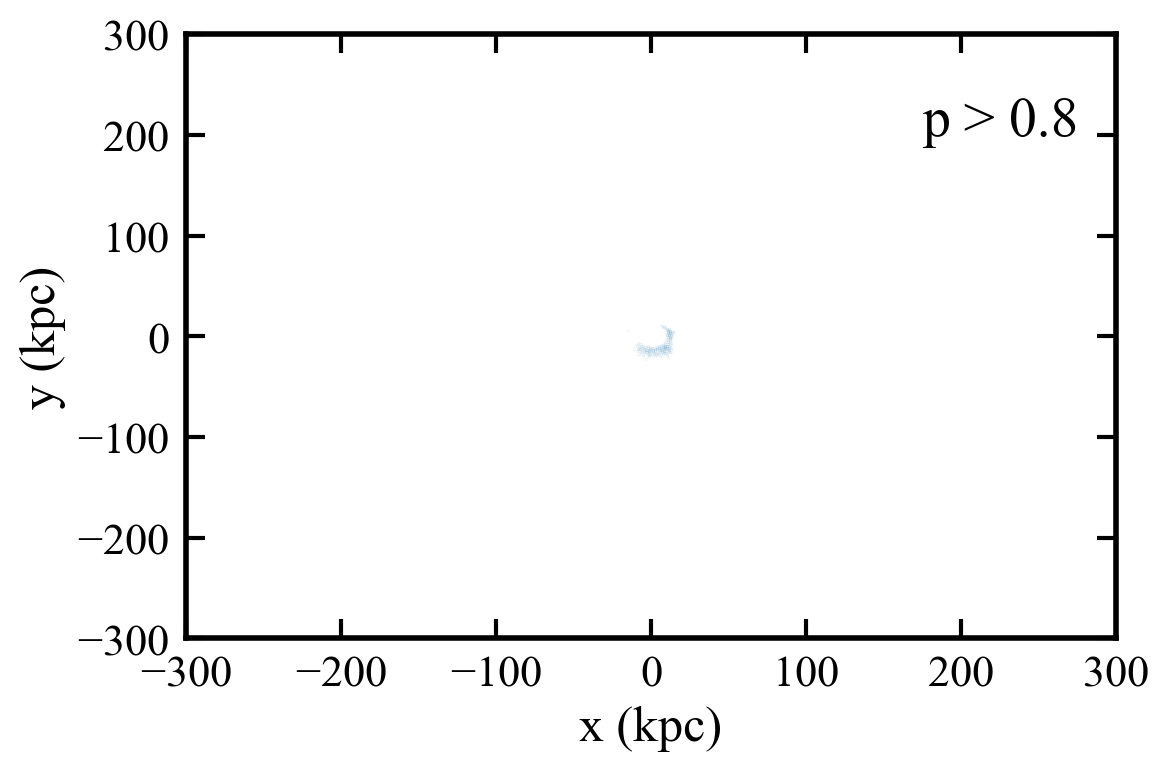

In [94]:
prob_list = [0.0,0.1,0.3,0.5, 0.8]

for prob_val in prob_list:
    mock_star_mask = np.ndarray.flatten((model_output>prob_val))
    in_gal_mask = (dist<300.0)

    dark_part_coords = coords[mock_star_mask&in_gal_mask]

    plt.scatter(dark_part_coords[:,0][::100]-host_cen[0],
                dark_part_coords[:,1][::100]-host_cen[1],marker='.',s=0.001)
    plt.xlim([-300.0,300.0])
    plt.ylim([-300.0,300.0])
    plt.text(175.0,200.0,'p > '+str(prob_val),fontsize=20)
    plt.xlabel('x (kpc)')
    plt.ylabel('y (kpc)')
    plt.show()

    #plt.scatter(dark_part_coords[:,1][::100]-host_cen[1],
    #            dark_part_coords[:,2][::100]-host_cen[2],marker='.',s=0.001)
    #plt.xlim([-300.0,300.0])
    #plt.ylim([-300.0,300.0])
    #plt.show()

    #plt.scatter(dark_part_coords[:,2][::100]-host_cen[2],
    #            dark_part_coords[:,0][::100]-host_cen[0],marker='.',s=0.001)

    #plt.xlim([-300.0,300.0])
    #plt.ylim([-300.0,300.0])
    #plt.show()

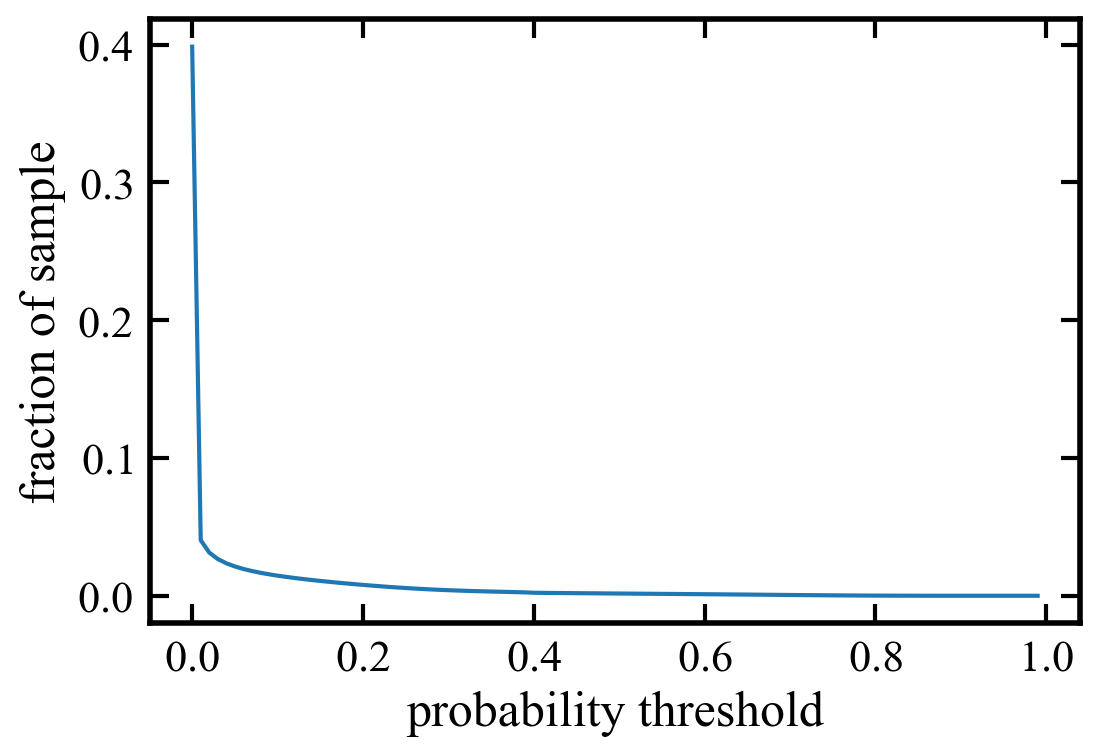

In [73]:
fraction_list = []

for prob_val in np.arange(0.0,1.0,0.01):
    frac = float(np.sum(model_output>prob_val))/float(len(model_output))
    fraction_list.append(frac)
    
plt.plot(np.arange(0.0,1.0,0.01),fraction_list)
plt.xlabel('probability threshold')
plt.ylabel('fraction of sample')
plt.show()

In [75]:
arg_index = np.argmin(abs(0.004-np.array(fraction_list)))
threshold_list = np.arange(0.0,1.0,0.01)

p_thresh = threshold_list[arg_index]
frac_thresh = fraction_list[arg_index]

print p_thresh
print frac_thresh

0.3
0.00404367025489


(241063672, 3)
(241063672,)


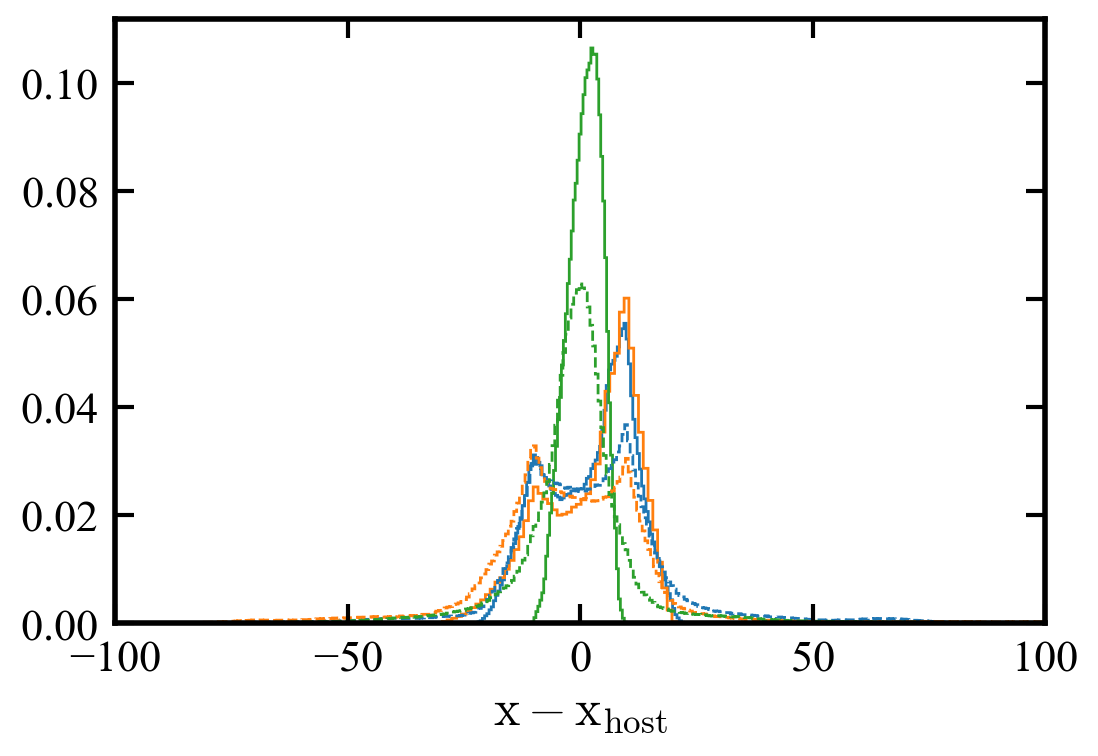

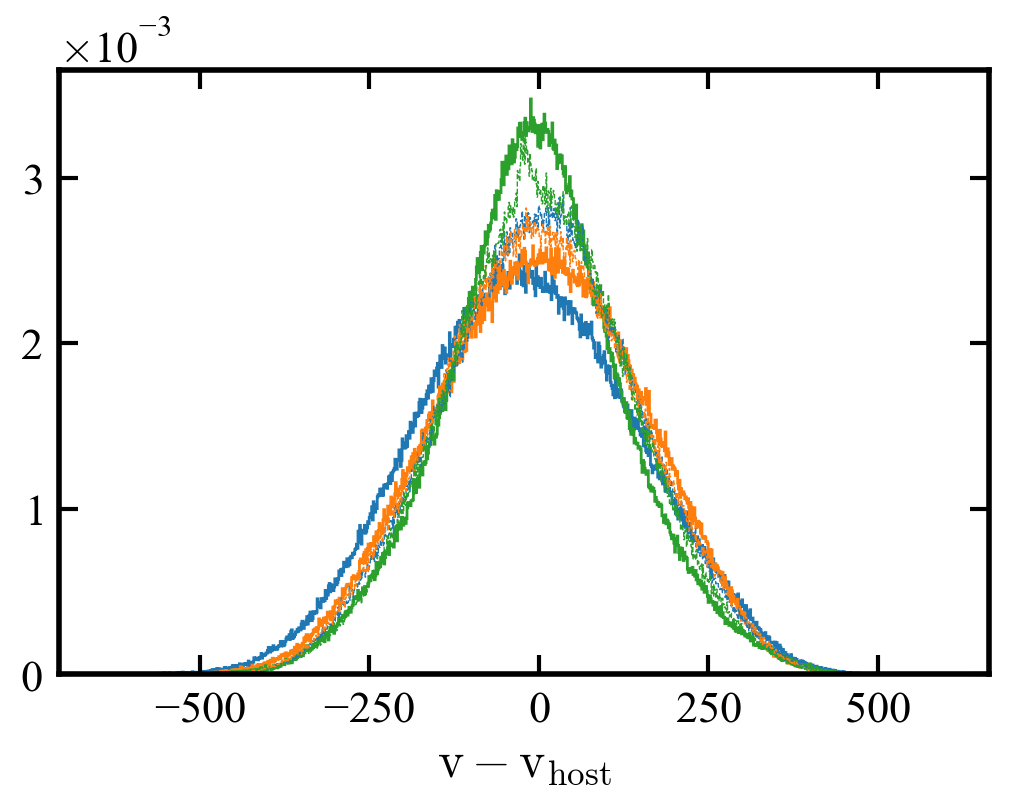

In [93]:
threshold_mask = np.ndarray.flatten(model_output>p_thresh)

print coord_diff.shape
print threshold_mask.shape

plt.hist(coord_diff[:,0][threshold_mask],bins=1000,histtype='step',normed=True,color='C0')
plt.hist(coord_diff[:,1][threshold_mask],bins=1000,histtype='step',normed=True,color='C1')
plt.hist(coord_diff[:,2][threshold_mask],bins=1000,histtype='step',normed=True,color='C2')

plt.hist(coords_train[:,0][M_star_mask] - host_pos_train[0],bins=1000,
         histtype='step',linestyle='--',normed=True,color='C0')
plt.hist(coords_train[:,1][M_star_mask] - host_pos_train[1],bins=1000,
         histtype='step',linestyle='--',normed=True,color='C1')
plt.hist(coords_train[:,2][M_star_mask] - host_pos_train[2],bins=1000,
         histtype='step',linestyle='--',normed=True,color='C2')

plt.xlim([-100.0,100.0])
plt.xlabel(r'$\rm x - x_{host}$')
#plt.ylim([-300.0,300.0])

plt.show()

plt.hist(vel_diff[:,0][threshold_mask],bins=1000,histtype='step',normed=True,color='C0')
plt.hist(vel_diff[:,1][threshold_mask],bins=1000,histtype='step',normed=True,color='C1')
plt.hist(vel_diff[:,2][threshold_mask],bins=1000,histtype='step',normed=True,color='C2')

plt.hist(vel_train[:,0][M_star_mask] - host_vel_train[0],bins=1000,linestyle='--'
         ,lw=0.5,histtype='step',normed=True,color='C0')
plt.hist(vel_train[:,1][M_star_mask] - host_vel_train[1],bins=1000,linestyle='--'
         ,lw=0.5,histtype='step',normed=True,color='C1')
plt.hist(vel_train[:,2][M_star_mask] - host_vel_train[2],bins=1000,linestyle='--'
         ,lw=0.5,histtype='step',normed=True,color='C2')
plt.xlabel(r'$\rm v - v_{host}$')

plt.show()

Text(0,0.5,'$\\rm N_{part}$')

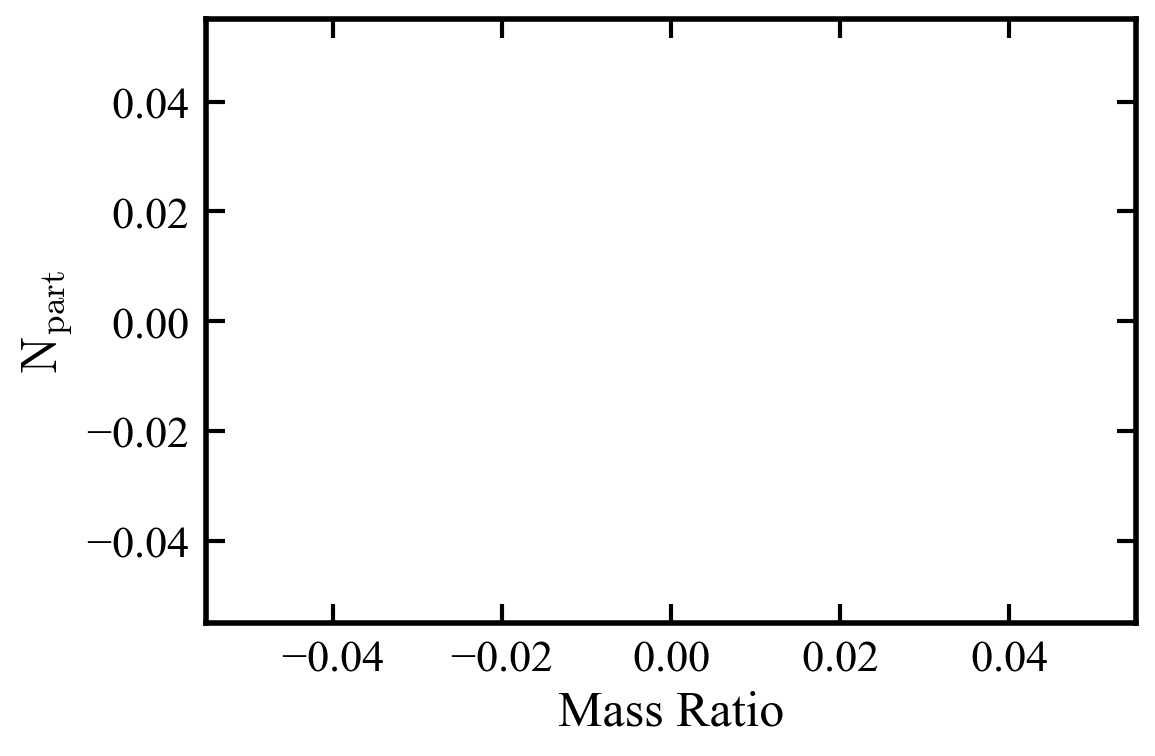

In [95]:
plt.plot([],[])
plt.xlabel('Mass Ratio')
plt.ylabel(r'$\rm N_{part}$')